# 2D Acoustic Wave
---
- Model Setup: [this link](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/01_modelling.ipynb)

- target: $c(x, z)^2$.

- rescaling: $x' = x/1000, z' = z/1000, t' = t/1000$.

---

# Pretrain: inverse problem

In [5]:
NAME = "0722_pretrain_inverse_problem"

In [6]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [8]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [2, 32, 32, 32, 1]
c = 10.0
w0 = 50.0
lambda_0 = 1e-5
# params = init_siren_params(random.PRNGKey(0), layers, c, w0)
iteration = 100000
params = np.load("models/{}/inverse_model/iteration_{}/params.npy".format(NAME, iteration), allow_pickle=True)
params = [[jnp.asarray(arr) for arr in Arr] for Arr in params]

@jax.jit
def scalar_model(params, x, z):
	x_ = jnp.hstack([x, z])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

model = jax.jit(jax.vmap(scalar_model, in_axes = (None, 0, 0)))

In [9]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def loss_fn_(params, batch):
	c_pred = model(params, batch.x, batch.z).reshape((-1, 1))
	return mse(c_pred, batch.c)

@jax.jit
def loss_fn(params, batch):
	return loss_fn_(params, batch) + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	return loss_fn_(params, batch)

In [11]:
domain = np.array([[0.0, 0.0], [1.0, 1.0]])
def c_fn(x, z):
	return np.piecewise(z, [z >= 0.5, z < 0.5], [2.5, 1.5])

key = random.PRNGKey(0)
key, *subkeys = random.split(key, 3)

n = 20000
x = transform(np.random.random((n, 1)), domain[0, 0], domain[1, 0])
z = transform(np.random.random((n, 1)), domain[0, 1], domain[1, 1])
c = c_fn(x, z)

Data = namedtuple("Data", ["x", "z", "c"])
batch = Data(*map(lambda x: jnp.array(x), [x, z, c]))

x_test = np.linspace(domain[0, 0], domain[1, 0], 100).reshape((-1, 1))
z_test = np.linspace(domain[0, 1], domain[1, 1], 100).reshape((-1, 1))
xz_test = tensor_grid([z_test, x_test])
xz_test[:, [0, 1]] = xz_test[:, [1, 0]]
c_test = c_fn(xz_test[:, 0:1], xz_test[:, 1:2])
batch_test = Data(*map(lambda x: jnp.array(x), [xz_test[:, 0:1], xz_test[:, 1:2], c_test]))

In [6]:
lr = 1e-4
iterations = 1000000
print_every = 10000
save_every = 100000

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(1, iterations+1):
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss"]
		params_ = get_params(opt_state)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, [evaluate(params_, batch)])]))
		print("{}, Iteration: {}, Test".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, [evaluate(params_, batch_test)])]))
		print("\n")
	if iteration % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/inverse_model/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/22, 23:48:50, Iteration: 10000, Train Loss: 2.6245e-02
2020/07/22, 23:48:50, Iteration: 10000, Test Loss: 3.4221e-02


2020/07/22, 23:48:56, Iteration: 20000, Train Loss: 5.5175e-03
2020/07/22, 23:48:56, Iteration: 20000, Test Loss: 7.2290e-03


2020/07/22, 23:49:01, Iteration: 30000, Train Loss: 4.0344e-03
2020/07/22, 23:49:01, Iteration: 30000, Test Loss: 4.9873e-03


2020/07/22, 23:49:06, Iteration: 40000, Train Loss: 3.5288e-03
2020/07/22, 23:49:06, Iteration: 40000, Test Loss: 4.2344e-03


2020/07/22, 23:49:11, Iteration: 50000, Train Loss: 3.1365e-03
2020/07/22, 23:49:11, Iteration: 50000, Test Loss: 3.7220e-03


2020/07/22, 23:49:16, Iteration: 60000, Train Loss: 2.9297e-03
2020/07/22, 23:49:16, Iteration: 60000, Test Loss: 3.4266e-03


2020/07/22, 23:49:21, Iteration: 70000, Train Loss: 2.6360e-03
2020/07/22, 23:49:21, Iteration: 70000, Test Loss: 2.8677e-03


2020/07/22, 23:49:26, Iteration: 80000, Train Loss: 2.5753e-03
2020/07/22, 23:49:26, Iteration: 80000, Test Los

2020/07/22, 23:54:19, Iteration: 650000, Train Loss: 2.3911e-04
2020/07/22, 23:54:19, Iteration: 650000, Test Loss: 6.6135e-05


2020/07/22, 23:54:24, Iteration: 660000, Train Loss: 2.4281e-04
2020/07/22, 23:54:24, Iteration: 660000, Test Loss: 6.2741e-05


2020/07/22, 23:54:29, Iteration: 670000, Train Loss: 2.4515e-04
2020/07/22, 23:54:29, Iteration: 670000, Test Loss: 6.4208e-05


2020/07/22, 23:54:34, Iteration: 680000, Train Loss: 2.5096e-04
2020/07/22, 23:54:34, Iteration: 680000, Test Loss: 7.3931e-05


2020/07/22, 23:54:39, Iteration: 690000, Train Loss: 2.6144e-04
2020/07/22, 23:54:39, Iteration: 690000, Test Loss: 7.8321e-05


2020/07/22, 23:54:44, Iteration: 700000, Train Loss: 2.8055e-04
2020/07/22, 23:54:44, Iteration: 700000, Test Loss: 8.2552e-05


2020/07/22, 23:54:49, Iteration: 710000, Train Loss: 3.0416e-04
2020/07/22, 23:54:49, Iteration: 710000, Test Loss: 9.9735e-05


2020/07/22, 23:54:54, Iteration: 720000, Train Loss: 3.1580e-04
2020/07/22, 23:54:54, Iteration: 

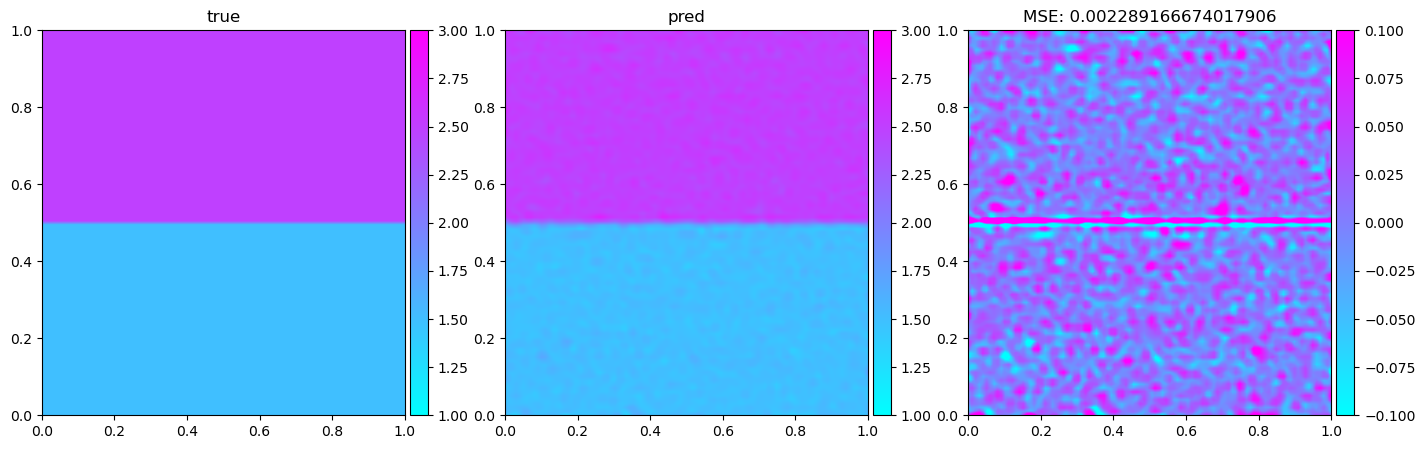

In [16]:
c_pred = model(get_params(opt_state), batch_test.x, batch_test.z).reshape((-1, 1))

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=1.0, vmax=3.0)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_test.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
im1 = ax[1].contourf(X, Z, c_pred.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-1, vmax=1e-1)
im2 = ax[2].contourf(X, Z, c_test.reshape((len(z_test), len(x_test)))-c_pred.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("MSE: {}".format(np.mean(np.square(c_test - c_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()